In [2]:
import os
import shutil
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense,Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import numpy as np
import tkinter as tk
from tkinter import filedialog
from PIL import ImageTk, Image
from tensorflow.keras.models import load_model

In [3]:
tb_dir = r"C:\Datasets\TB_Chest_Radiography_Database\Tuberculosis"
normal_dir =r"C:\Datasets\TB_Chest_Radiography_Database\Normal"

train_dir = 'Train'
validation_dir = 'Validation'

os.makedirs(os.path.join(train_dir,'Tuberculosis'),exist_ok=True)
os.makedirs(os.path.join(validation_dir,'Tuberculosis'),exist_ok=True)

os.makedirs(os.path.join(train_dir,'Normal'),exist_ok=True)
os.makedirs(os.path.join(validation_dir,'Normal'),exist_ok=True)

def move_images(image_list, destination_dir):
    for img_path in image_list:
        img_name = os.path.basename(img_path)
        destination_path = os.path.join(destination_dir, img_name)
        shutil.copy(img_path, destination_path)

tb_images = [os.path.join(tb_dir, img) for img in os.listdir(tb_dir)]
normal_images = [os.path.join(normal_dir, img) for img in os.listdir(normal_dir)]

random.shuffle(tb_images)
random.shuffle(normal_images)

s_ratio = 0.8

tb_train_count = int(len(tb_images) * s_ratio)
normal_train_count = int(len(normal_images) * s_ratio)

tb_train_images = tb_images[:tb_train_count]
tb_validation_images = tb_images[tb_train_count:]

normal_train_images = normal_images[:normal_train_count]
normal_validation_images =  normal_images[normal_train_count:]

# Move images to their respective directories for training and validation
move_images(tb_train_images, os.path.join(train_dir, 'Tuberculosis'))
move_images(tb_validation_images, os.path.join(validation_dir, 'Tuberculosis'))

move_images(normal_train_images, os.path.join(train_dir, 'Normal'))
move_images(normal_validation_images, os.path.join(validation_dir, 'Normal'))

print("Data split and moved successfully!")

Data split and moved successfully!


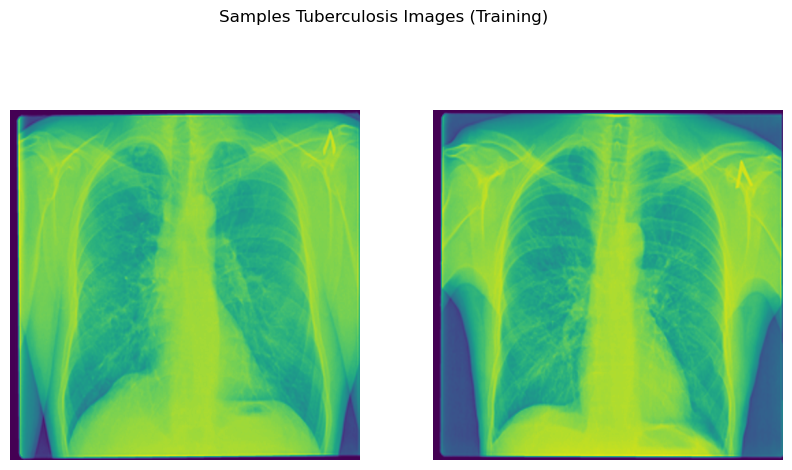

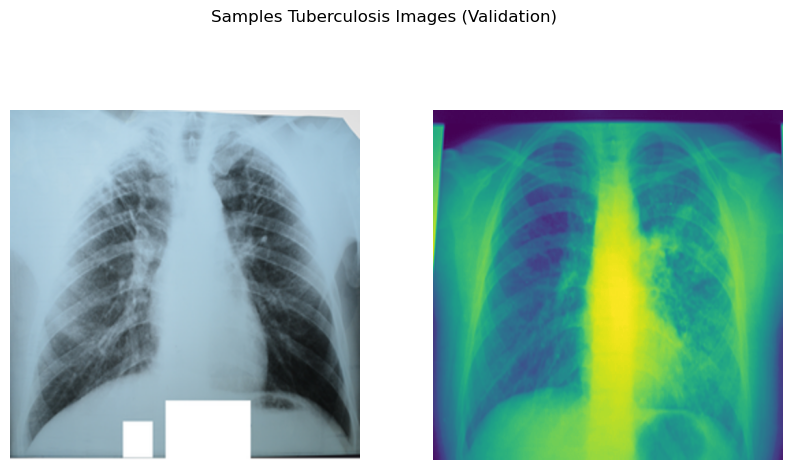

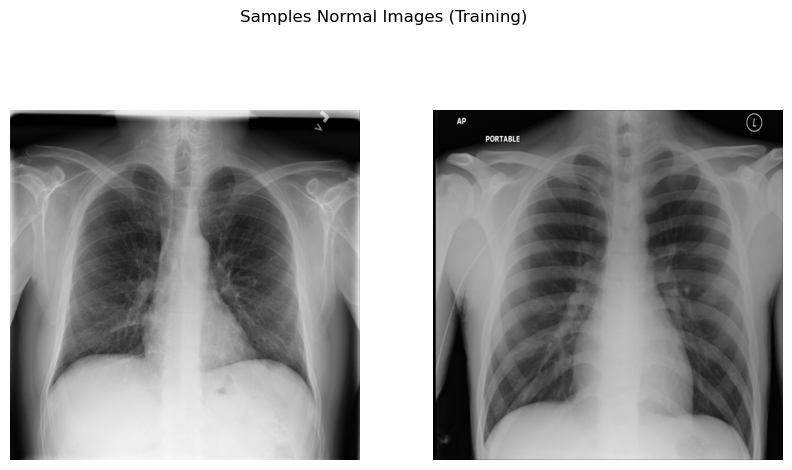

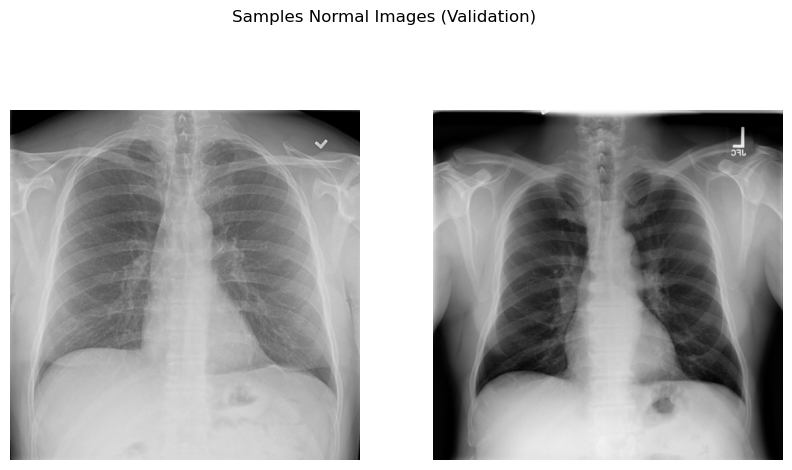

In [9]:
def display_random_images(image_list, title):
    plt.figure(figsize=(10, 10))
    for i in range(2):
        img_path = random.choice(image_list)
        img = mpimg.imread(img_path)
        plt.subplot(2, 2, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

display_random_images(tb_train_images, 'Samples Tuberculosis Images (Training)')
display_random_images(tb_validation_images, 'Samples Tuberculosis Images (Validation)')

display_random_images(normal_train_images, 'Samples Normal Images (Training)')
display_random_images(normal_validation_images, 'Samples Normal Images (Validation)')



In [19]:
img_width , img_ht = 512, 512
batch_size = 16

# Data Augmentation and Normalization
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1. / 255)

# Flow training images in batches using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_ht),
    batch_size=batch_size,
    class_mode='binary')

# Flow validation images in batches using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_width, img_ht),
    batch_size=batch_size,
    class_mode='binary')


Found 3360 images belonging to 2 classes.
Found 840 images belonging to 2 classes.


In [20]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers
from tensorflow.keras import Model

base_model = VGG16(input_shape=(img_width, img_ht, 3),
                   include_top=False,
                   weights='imagenet')

for layer in base_model.layers:
    layer.trainable = False

x = layers.Flatten()(base_model.output)

x = layers.Dense(512, activation='relu')(x)

x = layers.Dropout(0.5)(x)

output = layers.Dense(1, activation='sigmoid')(x)


In [15]:
model = Model(base_model.input, output)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [21]:
history = model.fit(train_generator,
                    epochs=3,
                    validation_data=validation_generator)

Epoch 1/3
210/210 [==============================] - 1833s 9s/step - loss: 0.4846 - accuracy: 0.8714 - val_loss: 0.2348 - val_accuracy: 0.8917
Epoch 2/3
210/210 [==============================] - 1790s 9s/step - loss: 0.2312 - accuracy: 0.8967 - val_loss: 0.1928 - val_accuracy: 0.8571
Epoch 3/3
210/210 [==============================] - 1716s 8s/step - loss: 0.2620 - accuracy: 0.8848 - val_loss: 0.1556 - val_accuracy: 0.9024


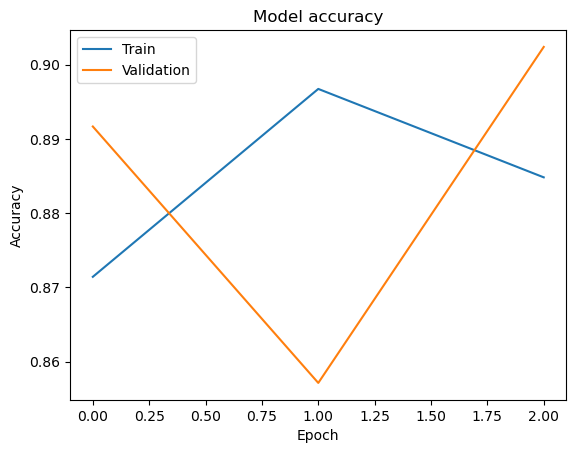

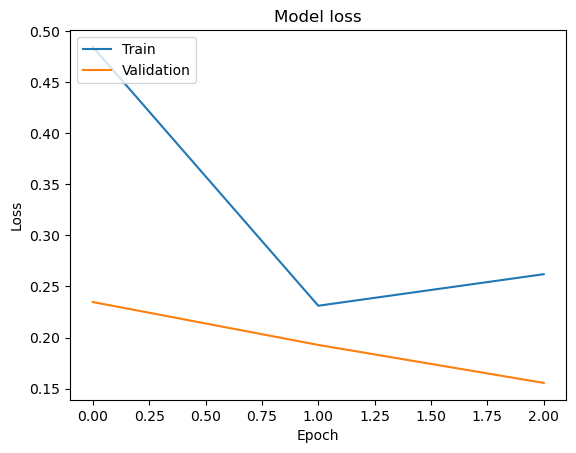

In [22]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [23]:
model_path = 'tb_model.h5'

model.save(model_path)

print("Model saved successfully.")


c:\Users\sound\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved successfully.


1/1 [==============================] - 1s 805ms/step
Predicted class: Normal


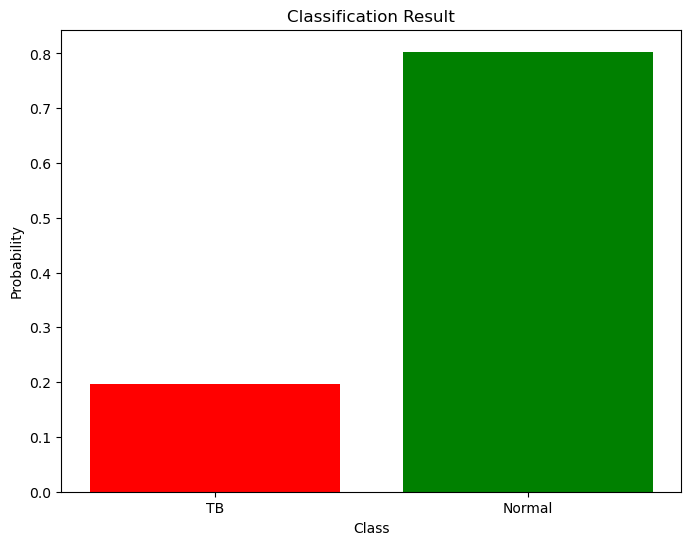

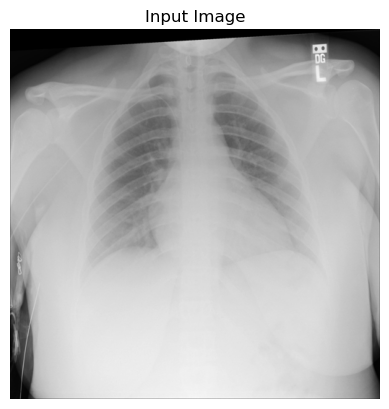

In [12]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

image = Image.open(r"E:\Binary Writing\New folder (3)\Train\Normal\Normal-5.png")

image = image.resize((512, 512))

image_array = np.array(image)

image_array = np.expand_dims(image_array, axis=0)

image_array = image_array / 255.0  

prediction = model.predict(image_array)

def predict_class(prediction):
    if prediction > 0.5:
        return "TB"
    else:
        return "Normal"

predicted_class = predict_class(prediction)
print("Predicted class:", predicted_class)

plt.figure(figsize=(8, 6))
classes = ["TB", "Normal"]
probabilities = [prediction[0][0], 1 - prediction[0][0]]  # Probability of TB and Normal
plt.bar(classes, probabilities, color=['red', 'green'])
plt.xlabel('Class')
plt.ylabel('Probability')
plt.title('Classification Result')
plt.show()

plt.imshow(image)
plt.axis('off')  
plt.title('Input Image')
plt.show()
